### This cell downloads the data
* Log-returns are calculated, number of simultaneous parents specified, and size of simulation samples specified, among other things. 
* Line 22 is a modification specific to this data set. Closing prices of all stocks on 14/06/2022 where replaced by the respective averages of 13/06/2022 and 15/06/2022 after identifying that several of the stocks had outliers on 14/06/2022. 


In [3]:
%%time 
import numpy as np                                          # load modules
import pandas as pd
import yfinance as yf

start_date, end_date = "2014-01-01", "2022-06-30"      # specifies time length
                                                    # Entries here should be entered as desired                              
number_of_sp = 1                                # desired number of simultaneous parents                                    
K = N = 2000                           # size of simulation samples
tickers = ['BTI.JO', 'GLN.JO', 'CFR.JO', 'AGL.JO', 'NPN.JO', 'AMS.JO', 'FSR.JO', 'SBK.JO', 'MTN.JO', 'VOD.JO',
           'SOL.JO', 'CPI.JO', 'KIO.JO', 'IMP.JO', 'ABG.JO', 'BAW.JO', 'SHP.JO', 'NED.JO', 'ANG.JO', 'DSY.JO',
           'BVT.JO', 'CLS.JO', 'EXX.JO', 'REM.JO', 'APN.JO', 'PSG.JO', 'WHL.JO', 'NRP.JO', 'MRP.JO', 'ARI.JO',
           'TKG.JO', 'SAP.JO', 'SNT.JO', 'PIK.JO', 'TCP.JO', 'SPP.JO', 'INL.JO', 'TBS.JO', 'TRU.JO', 'AVI.JO']

all_stocks = tickers                       # assign all_stocks the full list of stocks, to be used later

Close = pd.DataFrame(columns = tickers)                           # ensures that data comes in a data frame

for ticker in tickers:                                           # downloads prices of stocks from Yahoo! Finance
    Close[ticker] = yf.download(ticker, start_date, end_date, progress = False)['Close']

Close[2151:2152] = Close[2151:2152].multiply(np.nan) # changes entire row to nan
   
print('Missing stock prices before filling gaps =', Close.isnull().sum().sum())
Close = Close.interpolate(limit_direction = 'both')                  # fills missing values using linear interpolation
print('Missing stock prices after filling gaps =', Close.isnull().sum().sum())  
print('Lenght of closing prices = ', len(Close))
print(" ")

returns = np.log(Close[tickers]).diff()      # calculates log-returns
data = returns[1:]
print("TABLE SHOWING  CLOSING PRICES")
print(Close[0:5])
print(" ")
print("TABLE SHOWING  LOG-RETURNS")
print(data[0:5])

Missing stock prices before filling gaps = 42
Missing stock prices after filling gaps = 0
Lenght of closing prices =  2162
 
TABLE SHOWING  CLOSING PRICES
             BTI.JO  GLN.JO   CFR.JO   AGL.JO        NPN.JO   AMS.JO  FSR.JO  \
Date                                                                           
2014-01-01  56013.0  5481.0  10458.0  22900.0  68860.992188  39391.0  3589.0   
2014-01-02  56246.0  5409.0  10700.0  22699.0  69487.398438  39701.0  3571.0   
2014-01-03  55909.0  5349.0  10499.0  22500.0  68153.546875  39900.0  3550.0   
2014-01-06  56144.0  5364.0  10490.0  22406.0  68002.757812  39372.0  3462.0   
2014-01-07  55757.0  5370.0  10245.0  22239.0  67855.109375  38765.0  3500.0   

             SBK.JO   MTN.JO   VOD.JO  ...  TKG.JO  SAP.JO   SNT.JO  PIK.JO  \
Date                                   ...                                    
2014-01-01  12942.0  21702.0  13300.0  ...  2800.0  3275.0  18628.0  5200.0   
2014-01-02  13031.0  21714.0  13261.0  ...  283

### This cell selects the simultaneous parent(s) for each stock (Phase 1)

In [4]:
%%time
from scipy.linalg import block_diag

beta, delta_phi, delta_gamma, time_length_1  = 0.922, 0.993, 0.953, range(0, 782)             # discount factors 

theta_list = []

for ticker in tickers:
    index = tickers.index(ticker)
    
    a = np.zeros((len(tickers), 1))                             # initialise the prior
    R_list, diag_element = [0.0001], 0.01
    R_list.extend([diag_element]*(len(tickers)-1))
    R = np.diag(R_list)
    c, r = 0.001, 5

    for t in time_length_1:
    
        F_list = [1]                   # formation of F. All the remaining stocks are sp of a particular stock   
        data_points = data.iloc[[t]].values.tolist()[0] 
        data_points.pop(index)                         
        F_list.extend(data_points)  
        F = np.array([[i] for i in F_list])  
 
        f = F.transpose() @ a
        q = (F.transpose() @ R) @ F + c            # Kalman filter equatioins for forecasting and updating 
        e = data[ticker][t] - f
        A = (R @ F)/q        
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r+1 
        s = z*c 
        
        a =  m                                           # evolution equations
        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)
        R = C + W
        c = s 
        r = beta*n
        
    m = m.flatten()                          # convert the posterior mean column vector into a row vector 
    theta_list.append(np.absolute(m))
theta_list                          # list of posteriors for all stocks on the last day of time_length_1

CPU times: total: 7.55 s
Wall time: 7.59 s


[array([0.00057566, 0.0375154 , 0.12906517, 0.0876151 , 0.01653977,
        0.08698779, 0.17285697, 0.00865135, 0.0381114 , 0.20588917,
        0.03424769, 0.11674155, 0.05122547, 0.02389   , 0.13553336,
        0.00982168, 0.12292374, 0.11902198, 0.0217863 , 0.0461972 ,
        0.19438513, 0.14189204, 0.02179454, 0.23753149, 0.08314763,
        0.09814811, 0.11665864, 0.06024798, 0.03850263, 0.00388535,
        0.03315503, 0.06069764, 0.04505588, 0.17913755, 0.21162268,
        0.17248291, 0.42958669, 0.20352936, 0.01429111, 0.38926236]),
 array([6.33965851e-04, 7.59951697e-02, 1.72243448e-01, 6.81483409e-01,
        4.36284891e-02, 3.97413704e-02, 1.05173329e-01, 1.27984632e-01,
        9.98101247e-02, 1.82220688e-01, 2.25928846e-02, 3.67624501e-01,
        5.31812018e-02, 3.98572720e-02, 2.73694278e-01, 7.34345468e-02,
        2.89951415e-01, 4.41316397e-01, 9.26554813e-02, 1.50641126e-01,
        2.00305172e-01, 5.94740007e-01, 1.26082876e-01, 5.59322068e-01,
        1.82392369e-01

### This cell obtains the initial priors for the test phase (part of Phase 2)
* The discount factors are determined from another analysis

In [5]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
    
beta, delta_phi, delta_gamma, time_length_2, M = 0.922, 0.993, 0.953, range(782, 1288), len(tickers)


r_list, c_list, a, R_values, diag_element = [5], [0.001], np.zeros((number_of_sp+1), dtype = int ), [0.0001], 0.01

r_list.extend(r_list*(M-1))          # Initial information at prior stage: a, R, r, c
c_list.extend(c_list*(M-1))

a = np.array([[i] for i in a])
a_list = [a]
a_list.extend(a_list*(M-1))

R_values.extend([diag_element]*number_of_sp)
R = np.diag(R_values)
R_list = [R]
R_list.extend(R_list*(M-1))

for t in time_length_2:

    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists = [], [], [], []

    for ticker in tickers:
        index = tickers.index(ticker)            

        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      
        data_sp = data.drop([ticker], axis = 1)         
        tickers.remove(ticker)                            
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                     

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c    
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)    
                                               # IMPORTANCE SAMPLING. Generate an IS for all states and precisions 
        single_ticker_sp_sets_IS, theta_IS_list = [], []
        for i in range(0, N):
            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]  # returns for all stocks at time t  
            theta_IS = theta_IS_list[i]

            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)

        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
        all_theta_IS_lists.append(theta_IS_list)

    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)

    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
    
                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)                                         
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 

        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 

        n_initial = n_list[index]          # calculation of n 
        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)

    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list


CPU times: total: 4h 2min 57s
Wall time: 4h 8min 8s


### Test phase (Phase 3) 

In [6]:
%%time 
from scipy import special 
from scipy.optimize import fsolve
from math import gamma

beta, delta_phi, delta_gamma, time_length_3 = 0.922, 0.993, 0.953, range(1288, 2161) 
    
all_time_forecasts, all_time_cov_matrix, ESS_list, HN_list, upper_bound_list  = [], [], [], [], []  

all_ticker_m_lists = []
for t in time_length_3:
    
    n_list, all_sp_sets_IS, all_lamda_IS_lists, all_theta_IS_lists  = [], [], [], []
    all_y_lamda_lists, all_y_theta_lists, all_y_sp_sets, all_mu_lists = [], [], [], []

    m_list = []
    for ticker in tickers:
        
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks     
        
        a, R, r, c = a_list[index], R_list[index], r_list[index], c_list[index] # priors for individual stocks   

        gamma_values = theta_list[index][1:]      # obtains gamma values to guide in obtaining simultaneous parents

        data_sp = data.drop([ticker], axis = 1)         # drop the value of the current stock in the dataframe 
        tickers.remove(ticker)                          # remove its symbol from the columns       
        F_list = [data_sp[tickers[gamma_values.argsort()[-number_of_sp:][k]]][t] 
                  for k in range((number_of_sp-1), -1, -1)] #generate F vector by adding values of simultaneous parents
        F_list = [1] + F_list
        F = np.array([ [i] for i in F_list])
        all_stocks.insert(index, ticker)                    # get back full list of stocks  
        
        y_lamda_list = [np.random.gamma( (r/2),  (2/(r*c)), K)][0]    # simulation of precision lambda 
        all_y_lamda_lists.append(y_lamda_list)                        # joint for forecasting
        
        
        y_single_ticker_sp_sets = []  # JOINT FORECASTING 
        y_theta_list = []
        mu_list = []
        for i in range(0, K): 
            
            # simulation of state for forecasting               
            y_theta = np.random.multivariate_normal(a.flatten(), R/(c*y_lamda_list[i]), check_valid = 'warn')
            y_theta_list.append(y_theta.reshape(-1, 1))
            mu_list.append(y_theta[0])

            y_sp_set = [data[ticker][t] for ticker in tickers] # row of the entire dataframe at time t
            y_theta = y_theta_list[i]
            
            for i in range(0, M):
                for k in range(1, (number_of_sp + 1)): #formation of a row of the gamma matrix, K times for each stock 
                    if y_sp_set[i] == F[k][0]:
                        y_sp_set[i] = y_theta[k][0]
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp + 1)):
                    if y_sp_set[i] == y_theta[k][0]:
                        u = u + 1
                if u == 0:
                    y_sp_set[i] = 0
            y_single_ticker_sp_sets.append(y_sp_set)
        
        all_y_theta_lists.append(y_theta_list)
        all_mu_lists.append(mu_list)
        all_y_sp_sets.append(y_single_ticker_sp_sets)

        f = F.transpose() @ a        # Kalman filter equations for forecasting and  updating to naive posterior
        q = F.transpose() @ R @ F + c        
        e = data[ticker][t] - f 
        A = (R @ F)/q
        z = (r + (e**2)/q)/(r+1)
        m = a +A*e
        m_list.append(m[1:])
        C = (R-(A @ A.transpose())*q)*z
        n = r + 1
        n_list.append(n)
        s = z*c; s = s[0][0]

        # IMPORTANCE SAMPLING 
        lamda_IS_list = [np.random.gamma( (n/2),  (2/(n*s)), N)][0]        # simulation of precision lambda for IS 
        all_lamda_IS_lists.append(lamda_IS_list)
                                               
        single_ticker_sp_sets_IS, theta_IS_list = [], []    
        for i in range(0, N):
            # simulation of state for IS                
            theta_IS = np.random.multivariate_normal(m.flatten(), C/(s*lamda_IS_list[i]), check_valid = 'warn')
            theta_IS_list.append(theta_IS.reshape(-1, 1))

            sp_set_IS = [data[ticker][t] for ticker in tickers]    # returns for all stocks at time t
            theta_IS = theta_IS_list[i]
            for i in range(0, M):
                for k in range(1, (number_of_sp+1)):                   # formation of a row of the gamma matrix 
                    if sp_set_IS[i] == F[k][0]:
                        sp_set_IS[i] = theta_IS[k][0]               
            for i in range(0, M):
                u = 0
                for k in range(1, (number_of_sp+1)): 
                    if sp_set_IS[i] == theta_IS[k][0]:
                        u = u + 1
                if u == 0:
                    sp_set_IS[i] = 0
            single_ticker_sp_sets_IS.append(sp_set_IS)
        
        all_theta_IS_lists.append(theta_IS_list)
        all_sp_sets_IS.append(single_ticker_sp_sets_IS)
    
    all_ticker_m_lists.append(m_list)

    IS_weight_list = []
    for T in range(0, N):                                              # formation of the Gamma_t matrix in the IS     
        Gamma_rows = [all_sp_sets_IS[j][T] for j in range(0, M)]    
        Gamma_IS = np.array(Gamma_rows)                                    # Gamma_IS is the gamma matrix in the IS  
        IS_weight = np.absolute(np.linalg.det( np.identity(M) - Gamma_IS ))                   # IS weights 
        IS_weight_list.append(IS_weight)
    IS_weight_array = np.array(IS_weight_list)
    alpha = (1/np.sum(IS_weight_array))*IS_weight_array                         # normalised IS weights (alpha)
    
    ESS = 1/sum(alpha**2) # effective sample size
    ESS_list.append(ESS) 
    
    entropy_list = [alpha[i]*np.log(N*alpha[i]) for i in range(0, N) ] # calculation of entropy 
    HN =  sum(entropy_list)
    HN_list.append(HN)
    
    upper_bound = N/ESS - 1
    upper_bound_list.append(upper_bound)
    
    # JOINT FORECASTING
    first_moment_list, second_moment_list = [], []            
    for T in range(0, K): 
        Gamma_rows  = [all_y_sp_sets[j][T] for j in range(0, M)]
        Gamma_t =  np.array(Gamma_rows)               # gamma matrix 
        mu_t    = np.array([all_mu_lists[j][T] for j in range(0, M)]).reshape(-1, 1) # mu vector containing phis
        
        first_moment = np.linalg.pinv(np.identity(M) - Gamma_t) @ mu_t  # forecasts vector 
        first_moment_list.append(first_moment)
        
        Lamda_t = np.diag([all_y_lamda_lists[j][T] for j in range(0, M) ] ) # covariance matrix, Sigma_t
        second_moment = np.linalg.pinv( (np.identity(M) - Gamma_t).transpose()@Lamda_t@(np.identity(M) - Gamma_t) )
        second_moment_list.append(second_moment)
    
    cov_matrix_t = sum(second_moment_list)/K           # covariance matrix at time t from ramdom sample
    all_time_cov_matrix.append(cov_matrix_t)
    
    MC_mean = sum(first_moment_list)/K              # forecasts at time t from ramdom sample
    MC_mean = MC_mean.flatten()
    forecasts_t = sum((np.random.multivariate_normal(MC_mean, cov_matrix_t, K, check_valid = 'warn')))/K
    all_time_forecasts.append(forecasts_t) 
    
    n_list_2, a_temp_list, R_temp_list, r_temp_list, c_temp_list = [], [], [], [], []
    
                          # VB starts here 
    for ticker in tickers: 
        index = tickers.index(ticker)  # assigns positions/numbers to stocks in the list of stocks                                        
        lamda_IS_list  = all_lamda_IS_lists[index] # the list of all lambda values in the IS for a single stock 
        theta_IS_list  = all_theta_IS_lists[index] # list of all theta values in the IS for a single stock

        m_num_list = [alpha[i]*lamda_IS_list[i]*theta_IS_list[i] for i in range(0, N)]
        m_den_list = [alpha[i]*lamda_IS_list[i] for i in range(0, N)]
        m = sum(m_num_list)/sum(m_den_list)              # Calculation of m from the VB formula 


        V = sum([alpha[i] * lamda_IS_list[i] * (theta_IS_list[i]-m) @ (theta_IS_list[i]-m).transpose()
                 for i in range(0, N) ])   # calculation of V using the VB formula 

        d = sum([alpha[i]*lamda_IS_list[i]*((theta_IS_list[i] - m).transpose() @ np.linalg.pinv(V) @ 
                (theta_IS_list[i] - m)) for i in range(0, N)])[0][0]     # calculation of d

        p_j = len(theta_IS)           # size of state vector in phases 2 and 3 

        n_initial = n_list[index]          # calculation of n 
        sum_1 = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N) ])
        sum_2 = sum([alpha[i] * np.log(lamda_IS_list[i]) for i in range(0, N) ])
        func = lambda n: (np.log(abs(n+p_j - d)) - special.polygamma(0, (n/2)) - (p_j - d)/n -
                          np.log(abs( 2 * sum_1)) + sum_2)
        n =  fsolve(func, [n_initial])[0]
        n_list_2.append(n)

        sum_in_s = sum([alpha[i] * lamda_IS_list[i] for i in range(0, N)]) # calculation of s
        s =(n + p_j - d)/(n*sum_in_s) 

        C = s*V                     # Calculation of C

        a =  m                          # kalman filter equations, evolution to the next day 
        a_temp_list.append(a)           # parameters are stored in temporary lists named as temp

        block_1 = [[C[0][0] * (1/delta_phi-1)]]          # block discounting 
        block_2 = C[1:, 1:] * (1/delta_gamma-1)
        W  = block_diag(block_1, block_2)

        R = C + W
        R_temp_list.append(R) 
        r = beta*n
        r_temp_list.append(r)
        c = s
        c_temp_list.append(c)

    a_list = a_temp_list       # fetch parameters from temporaly lists to move to the next value of t 
    R_list = R_temp_list
    r_list = r_temp_list
    c_list = c_temp_list
    

CPU times: total: 13h 44min 11s
Wall time: 13h 55min 52s


### Calculation of forecast intervals 

In [19]:
T = len(time_length_1) + len(time_length_2)
all_time_var = [np.diag(all_time_cov_matrix[i]) for i in range(0, len(all_time_cov_matrix))]

all_ticker_interval_values = []
all_ticker_lower_lists = []
all_ticker_upper_lists = []
for ticker in tickers: 
    print( " ")
    index = tickers.index(ticker)
    ticker_interval_values = []
    
    lower_list = []
    upper_list = []
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        var = all_time_var[i][index]
        
        interval = 2.58 * (var)**0.5 * (1 + 1/K)**0.5
        lower = forecast - interval 
        lower_list.append(lower)
        upper = forecast + interval
        upper_list.append(upper)
        if data[ticker][T+i] >= lower and data[ticker][T+i] <= upper:    
            ticker_interval_values.append(data[ticker][T+i])
            all_ticker_interval_values.append(data[ticker][T+i])
    ticker_interval_coverage =  len(ticker_interval_values)/(len(all_time_forecasts))*100    
    print('Interval coverage for', ticker,  'is ', round(ticker_interval_coverage, 1),'%') 
    
    all_ticker_lower_lists.append(lower_list)
    all_ticker_upper_lists.append(upper_list)
    
total_interval_coverage = len(all_ticker_interval_values)/(len(all_time_forecasts)*len(tickers))*100                 
                                                                                                       
print(' ')                                                                                                                                                                                              
print('Interval coverage in the aggregate is ', round(total_interval_coverage, 1),'%')       

 
Interval coverage for BTI.JO is  98.6 %
 
Interval coverage for GLN.JO is  99.0 %
 
Interval coverage for CFR.JO is  97.8 %
 
Interval coverage for AGL.JO is  98.4 %
 
Interval coverage for NPN.JO is  98.2 %
 
Interval coverage for AMS.JO is  98.6 %
 
Interval coverage for FSR.JO is  99.2 %
 
Interval coverage for SBK.JO is  99.0 %
 
Interval coverage for MTN.JO is  97.8 %
 
Interval coverage for VOD.JO is  98.4 %
 
Interval coverage for SOL.JO is  98.1 %
 
Interval coverage for CPI.JO is  98.3 %
 
Interval coverage for KIO.JO is  98.5 %
 
Interval coverage for IMP.JO is  98.6 %
 
Interval coverage for ABG.JO is  98.9 %
 
Interval coverage for BAW.JO is  97.9 %
 
Interval coverage for SHP.JO is  97.8 %
 
Interval coverage for NED.JO is  98.9 %
 
Interval coverage for ANG.JO is  98.6 %
 
Interval coverage for DSY.JO is  98.9 %
 
Interval coverage for BVT.JO is  98.9 %
 
Interval coverage for CLS.JO is  98.4 %
 
Interval coverage for EXX.JO is  98.5 %
 
Interval coverage for REM.JO is 

### Effective sample size

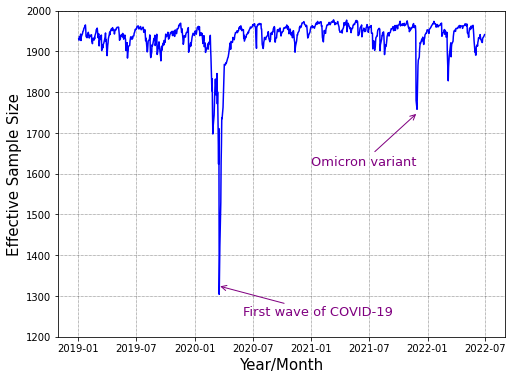

In [8]:
import matplotlib.pyplot as plt
from datetime import datetime

T_2 = len(time_length_1) + len(time_length_2)
T_3 = len(time_length_1) + len(time_length_2) + len(time_length_3)

ESS = pd.DataFrame(data[tickers[0]][T_2:T_3])
ESS["ESS"] = (ESS_list) 
ESS.drop(ESS.columns[[0]], axis=1, inplace=True)

plt.figure(figsize = (8, 6))
plt.plot(ESS, color = 'blue')

plt.xlabel("Year/Month", fontsize = 15)
plt.ylabel("Effective Sample Size", fontsize = 15)
plt.ylim([1200, N])
plt.grid(color = 'black', linestyle = ':', linewidth = 0.5)
plt.annotate('First wave of COVID-19', xy=(datetime(2020,3,15), 1325), 
             xytext=(datetime(2020,6,1), 1260),
arrowprops={'arrowstyle': '->', 'color': 'purple'}, va='center', color = 'purple', 
             fontsize = 13)
plt.annotate('Omicron variant', xy=(datetime(2021,12,1), 1750), 
             xytext=(datetime(2021,1,1), 1630),
arrowprops={'arrowstyle': '->', 'color': 'purple'}, va='center', color = 'purple'
            , fontsize = 13)
#plt.savefig('ESS.pdf')
plt.show()


### Kullback-Leibler divergence

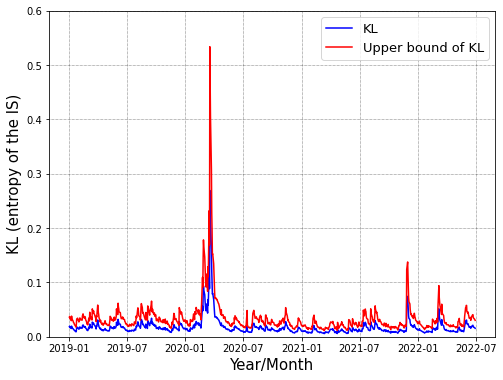

In [9]:
import matplotlib.pyplot as plt
KL = pd.DataFrame(data[tickers[0]][T_2:T_3])
KL['KL'] = (HN_list)  
KL.drop(KL.columns[[0]], axis=1, inplace=True)
KL["KL upper bound"] = (upper_bound_list) 

plt.figure(figsize = (8, 6))
plt.plot(KL['KL'], color = 'blue')
plt.plot(KL['KL upper bound'], color = 'red')

plt.xlabel("Year/Month", fontsize = 15)
plt.ylabel("KL (entropy of the IS)", fontsize = 15)
plt.ylim([0, 0.6])
plt.grid(color = 'black', linestyle = ':', linewidth = 0.5)
plt.legend(['KL', 'Upper bound of KL'], loc='upper right', fontsize = 13)
#plt.savefig('KL.pdf')
plt.show()

### Trends of the returns

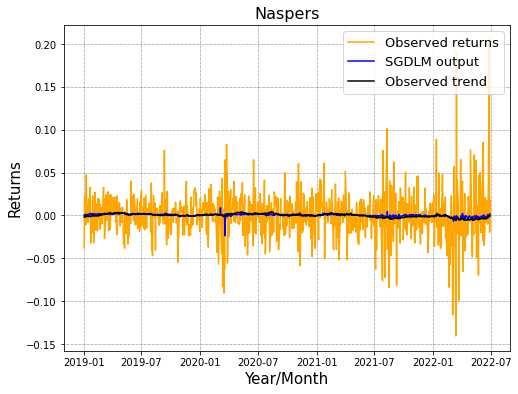

In [21]:
import matplotlib.pyplot as plt


ticker = 'NPN.JO'            # Specify ticker here 
MA_value =  100             # Specify level 

index = tickers.index(ticker)

model_returns = []
for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        model_returns.append(forecast)
        
returns = pd.DataFrame(data[tickers[index]][T_2:T_3])
returns["SGDLM returns"] = (model_returns)   
moving_average = data[tickers[index]].rolling(MA_value).mean()[T_2:T_3]
returns["trend"] = (moving_average )
    
plt.figure(figsize = (8, 6))
plt.plot(returns[ticker], color = 'orange')
plt.plot(returns['SGDLM returns'], color = 'blue')
plt.plot(returns['trend'], color = 'black')

plt.xlabel("Year/Month", fontsize = 15)
plt.ylabel("Returns", fontsize = 15)
plt.grid(color = 'black', linestyle = ':', linewidth = 0.5)
plt.legend(['Observed returns', 'SGDLM output', 'Observed trend'], loc = 'upper right', 
           fontsize = 13)
plt.title("Naspers", fontsize = 16)
#plt.savefig('NPN.pdf')
plt.show()

### Closing prices

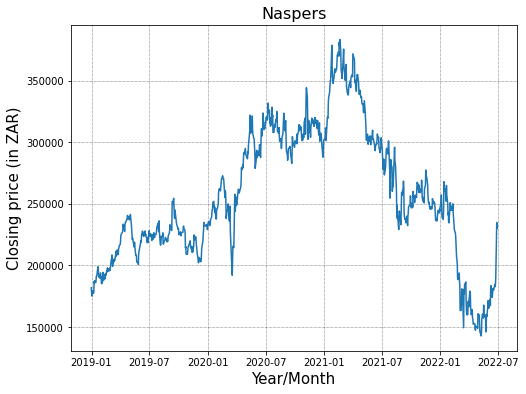

In [11]:
import matplotlib.pyplot as plt
ticker = 'NPN.JO'     
Close[ticker][T_2:]

plt.figure(figsize = (8, 6))
plt.plot(Close[ticker][T_2:T_3])

plt.xlabel("Year/Month", fontsize = 15)
plt.ylabel("Closing price (in ZAR)", fontsize = 15)
plt.grid(color = 'black', linestyle = ':', linewidth = 0.5)
plt.title("Naspers", fontsize = 16)
plt.savefig('NPN-close.pdf')
plt.show()

### RMSE and MAD for the SGDLM

In [12]:
T = len(time_length_1) + len(time_length_2)
for ticker in tickers: 
    print( " ")
    index = tickers.index(ticker)
    e_array = np.array([ ])
    for i in range(0, len(all_time_forecasts)):
        forecast = all_time_forecasts[i][index]
        e = data[ticker][T+i] - forecast
        e_array = np.append(e_array, e)
    RMSE = ( sum(e_array**2) / len(all_time_forecasts) )**0.5
    MAD = sum(np.absolute(e_array)) / len(all_time_forecasts)
    print('For' ,ticker,', RMSE = ', RMSE)
    print('For' ,ticker,', MAD = ', MAD)

 
For BTI.JO , RMSE =  0.017615488398068178
For BTI.JO , MAD =  0.01286870641821215
 
For GLN.JO , RMSE =  0.024451071325851302
For GLN.JO , MAD =  0.01812751487306927
 
For CFR.JO , RMSE =  0.020653009211390558
For CFR.JO , MAD =  0.014876634656197539
 
For AGL.JO , RMSE =  0.025199985071931455
For AGL.JO , MAD =  0.017938681978824752
 
For NPN.JO , RMSE =  0.026600538582083624
For NPN.JO , MAD =  0.018168392026835248
 
For AMS.JO , RMSE =  0.03419962850353993
For AMS.JO , MAD =  0.02400262933339413
 
For FSR.JO , RMSE =  0.023025916166490433
For FSR.JO , MAD =  0.016494814101868146
 
For SBK.JO , RMSE =  0.02345669431937479
For SBK.JO , MAD =  0.01653134570053968
 
For MTN.JO , RMSE =  0.03135161761483558
For MTN.JO , MAD =  0.02014464702184577
 
For VOD.JO , RMSE =  0.016975999898182957
For VOD.JO , MAD =  0.01176346096274325
 
For SOL.JO , RMSE =  0.057381062480566854
For SOL.JO , MAD =  0.029765629684040316
 
For CPI.JO , RMSE =  0.03541880451744144
For CPI.JO , MAD =  0.015996093